In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/medical-insurance-cost-dataset/insurance.csv


In [16]:
import pandas as pd

df = pd.read_csv("/kaggle/input/medical-insurance-cost-dataset/insurance.csv")

df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 1. Подготовка данных

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
age           0
bmi           9
children      0
charges     139
dtype: int64


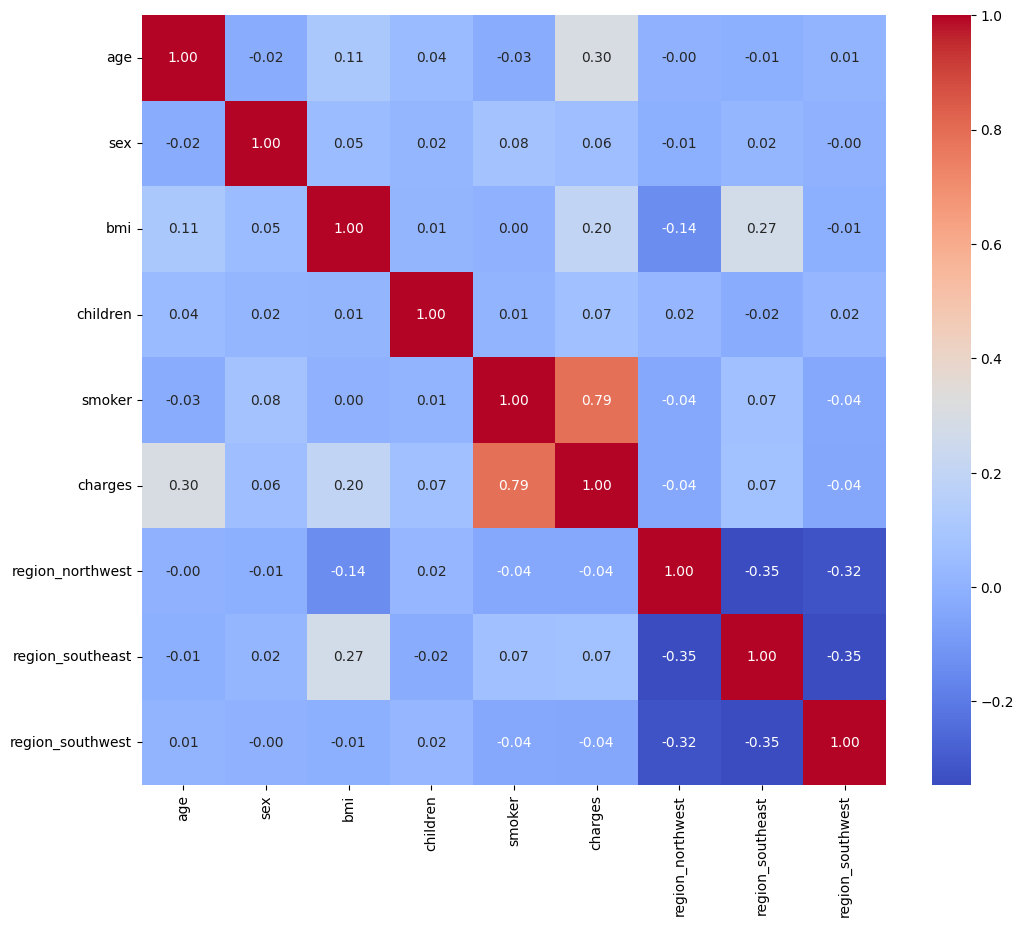

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print(df.isnull().sum())

numeric_cols = ['age', 'bmi', 'children', 'charges']
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).sum()
print(outliers)

df['sex'] = df['sex'].map({'male': 1, 'female': 0})
df['smoker'] = df['smoker'].map({'yes': 1, 'no': 0})
df = pd.get_dummies(df, columns=['region'], drop_first=True)

plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

In [18]:
df = df.dropna(subset=['bmi', 'charges'])
df.head()

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,False,False,True
1,18,1,33.770,1,0,1725.55230,False,True,False
2,28,1,33.000,3,0,4449.46200,False,True,False
3,33,1,22.705,0,0,21984.47061,True,False,False
4,32,1,28.880,0,0,3866.85520,True,False,False


In [19]:
df.shape

(1338, 9)

## 2. Многомерная линейная регрессия

In [20]:
from sklearn.model_selection import train_test_split

X = df.drop('charges', axis=1).astype(float)
y = df['charges'].astype(float)

X_normalized = (X - X.mean()) / X.std()
y_normalized = (y - y.mean()) / y.std()

X_with_intercept = np.column_stack([np.ones(X_normalized.shape[0]), X_normalized])

X_train, X_test, y_train, y_test = train_test_split(X_with_intercept, y_normalized, test_size=0.2, random_state=42)

In [21]:
theta_analytic = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train
print("Аналитическое решение:", theta_analytic)

def gradient_descent(X, y, alpha=0.01, iterations=10000):
    m = len(y)
    theta = np.zeros(X.shape[1])
    for i in range(iterations):
        gradient = (1/m) * X.T @ (X @ theta - y)
        theta -= alpha * gradient
    return theta

theta_gradient = gradient_descent(X_train, y_train)
print("Градиентный спуск:", theta_gradient)

Аналитическое решение: [ 3.62622923e-03  2.98141630e-01 -7.67861590e-04  1.69748264e-01
  4.23344352e-02  7.88423686e-01 -1.31311910e-02 -2.41840026e-02
 -2.86870257e-02]
Градиентный спуск: [ 3.62622923e-03  2.98141630e-01 -7.67861590e-04  1.69748264e-01
  4.23344352e-02  7.88423686e-01 -1.31311910e-02 -2.41840026e-02
 -2.86870257e-02]


## 3. Добавление регуляризации

In [22]:
lambda_reg = 0.1
n_features = X_train.shape[1]

theta_analytic_reg = np.linalg.inv(X_train.T @ X_train + lambda_reg * np.eye(n_features)) @ X_train.T @ y_train
print("Аналитическое решение с регуляризацией:", theta_analytic_reg)

def gradient_descent_reg(X, y, alpha=0.01, iterations=10000, lambda_reg=0.1):
    m = len(y)
    theta = np.zeros(X.shape[1])
    for i in range(iterations):
        gradient = (1/m) * X.T @ (X @ theta - y) + (lambda_reg/m) * theta
        theta -= alpha * gradient
    return theta

theta_gradient_reg = gradient_descent_reg(X_train, y_train)
print("Градиентный спуск с регуляризацией:", theta_gradient_reg)

Аналитическое решение с регуляризацией: [ 3.62623201e-03  2.98111860e-01 -7.62257308e-04  1.69732338e-01
  4.23334428e-02  7.88347860e-01 -1.31269244e-02 -2.41703926e-02
 -2.86800556e-02]
Градиентный спуск с регуляризацией: [ 3.62623201e-03  2.98111860e-01 -7.62257308e-04  1.69732338e-01
  4.23334428e-02  7.88347860e-01 -1.31269244e-02 -2.41703926e-02
 -2.86800556e-02]


## 4. Сравнение моделей

In [23]:
constant_pred = np.full_like(y_test, y_train.mean())
mse_constant = np.mean((constant_pred - y_test)**2)

analytic_pred = X_test @ theta_analytic
mse_analytic = np.mean((analytic_pred - y_test)**2)

reg_pred = X_test @ theta_analytic_reg
mse_reg = np.mean((reg_pred - y_test)**2)

print("MSE константная модель:", mse_constant)
print("MSE аналитическая регрессия:", mse_analytic)
print("MSE регуляризованная регрессия:", mse_reg)

MSE константная модель: 1.0595903864592768
MSE аналитическая регрессия: 0.22909220872570424
MSE регуляризованная регрессия: 0.22909762485836913
